# Uplift modeling

Client features before sending email:
* Recency: Months since last purchase.
* History_Segment: Categorization of dollars spent in the past year.
* History: Actual dollar value spent in the past year.
* Mens: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.
* Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.
* Zip_Code: Classifies zip code as Urban, Suburban, or Rural.
* Newbie: 1/0 indicator, 1 = New customer in the past twelve months.
* Channel: Describes the channels the customer purchased from in the past year.


Client group:
* Segment ("Mens E-Mail", "Womens E-Mail", "No E-Mail")

Client features within 2 weeks after sending email:
* Visit: 1/0 indicator, 1 = Customer visited website in the following two weeks.
* Conversion: 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.
* Spend: Actual dollars spent in the following two weeks.

In [1]:
# !pip install pylift
# !pip install scikit-uplift
# !pip install causalml
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from typing import List

In [10]:
import catboost as cb
import pylift
import causalml.metrics as cmetrics

from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import train_test_split

In [5]:
import sklift.metrics
import sklift.viz
import pylift_utils

In [7]:
data = pd.read_csv('data/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')

## EDA

In [15]:
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [12]:
data.describe()

,recency,history,mens,womens,newbie,visit,conversion,spend
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781,0.009031,1.050908
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890,0.094604,15.036448
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,499.000000


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64  
 10  conversion       64000 non-null  int64  
 11  spend            64000 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


In [17]:
data.columns

Index(['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'channel', 'segment', 'visit', 'conversion', 'spend'],
      dtype='object')

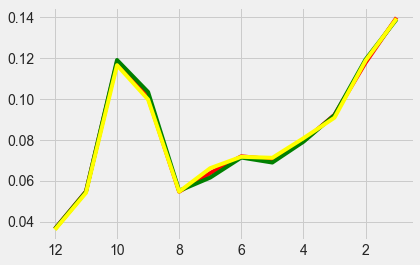

In [94]:
data.recency.value_counts(normalize=True).sort_index().plot(color='red').invert_xaxis()
data[data.segment == 'Mens E-Mail'].recency.value_counts(normalize=True).sort_index().plot(color='green').invert_xaxis()
data[data.segment == 'No E-Mail'].recency.value_counts(normalize=True).sort_index().plot(color='yellow').invert_xaxis()

<AxesSubplot:>

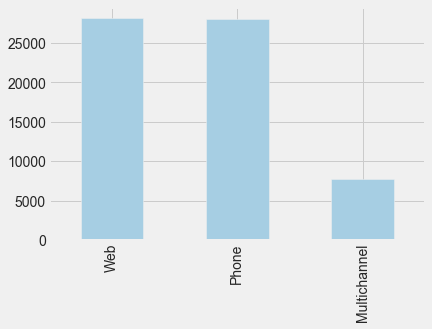

In [114]:
data.channel.value_counts().plot(kind='bar')

<AxesSubplot:>

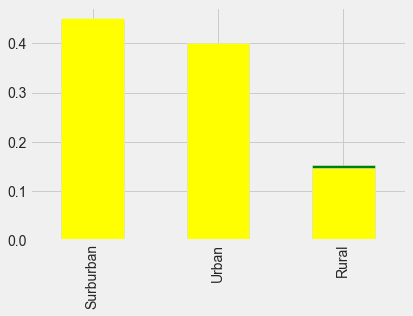

In [119]:
data.zip_code.value_counts(normalize=True).plot(kind='bar', color='red')
data[data.segment == 'Mens E-Mail'].zip_code.value_counts(normalize=True).plot(kind='bar', color='green')
data[data.segment == 'No E-Mail'].zip_code.value_counts(normalize=True).plot(kind='bar', color='yellow')

<AxesSubplot:>

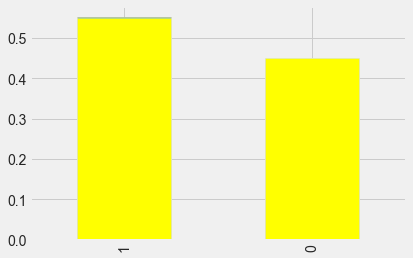

In [122]:
data.mens.value_counts(normalize=True).plot(kind='bar', color='red')
data[data.segment == 'Mens E-Mail'].mens.value_counts(normalize=True).plot(kind='bar', color='green')
data[data.segment == 'Womens E-Mail'].mens.value_counts(normalize=True).plot(kind='bar', color='yellow')

In [175]:
data_womens = data[data.segment.isin(["No E-Mail", "Womens E-Mail"])]
data_mens = data[data.segment.isin(["No E-Mail", "Mens E-Mail"])]
data_mens_womens = data[data.segment.isin(["Womens E-Mail", "Mens E-Mail"])]

In [ ]:
data_womens.loc[:, 'treatment'] = (data_womens['segment'] == "Womens E-Mail").astype('int32')
data_mens.loc[:, 'treatment'] = (data_mens['segment'] == "Mens E-Mail").astype('int32')
data_mens_womens.loc[:, 'treatment'] = (data_mens_womens['segment'] == "Womens E-Mail").astype('int32')

## Transform

In [177]:
def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, pd.get_dummies(data[cols])], axis=1)
    return result

def transform_(data: pd.DataFrame) -> pd.DataFrame:
    zipcode_num_dict = {
        'Urban': 0,
        'Surburban': 1,
        'Rural': 2
    }
    data['zip_code_num'] = data['zip_code'].map(zipcode_num_dict)

    channel_num_dict = {
        'Web': 0,
        'Multichannel': 1,
        'Phone': 2
    }
    data['channel_num'] = data['channel'].map(channel_num_dict)
    data['history_segment__label'] = data['history_segment'].str[0]
    data = one_hot_encode(data, cols=['zip_code', 'channel', 'history_segment__label'])
    return data

In [ ]:
data_womens = transform_(data_womens)
data_mens = transform_(data_mens)
data_mens_womens = transform_(data_mens_womens)

In [180]:
fit_index, val_index = train_test_split(data_womens.index, test_size=0.5, random_state=42)

In [181]:
column_set_n1 = [
    'recency',
    'mens',
    'womens',
    'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
    'channel_Multichannel', 'channel_Phone', 'channel_Web',
    'history_segment__label_1', 'history_segment__label_2',
    'history_segment__label_3', 'history_segment__label_4',
    'history_segment__label_5', 'history_segment__label_6',
    'history_segment__label_7'
]

In [182]:
upmodel_n0 = pylift.TransformedOutcome(
    data_womens.loc[fit_index, column_set_n1 + ['treatment', 'visit']],
    col_treatment='treatment', col_outcome='visit',
    test_size=2
)

In [183]:
upmodel_n0.fit()

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [184]:
eval_data = data_womens.loc[val_index, column_set_n1 + ['treatment', 'visit']]
eval_data['score'] = upmodel_n0.model.predict(eval_data[column_set_n1])
eval_data = eval_data[['score', 'treatment', 'visit']]

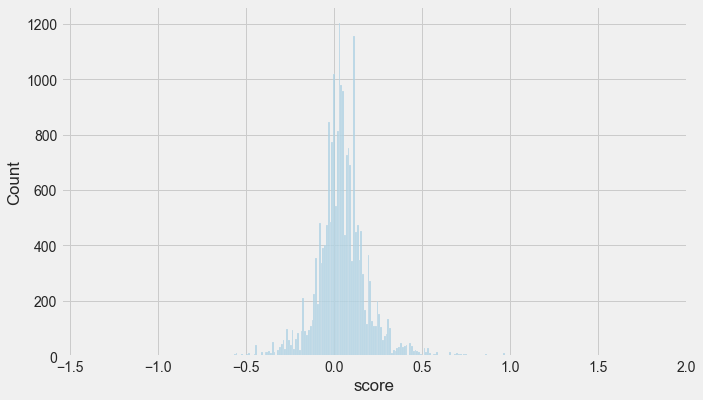

In [185]:
plt.figure(figsize=(10, 6))
sns.histplot(eval_data['score'])
plt.show()

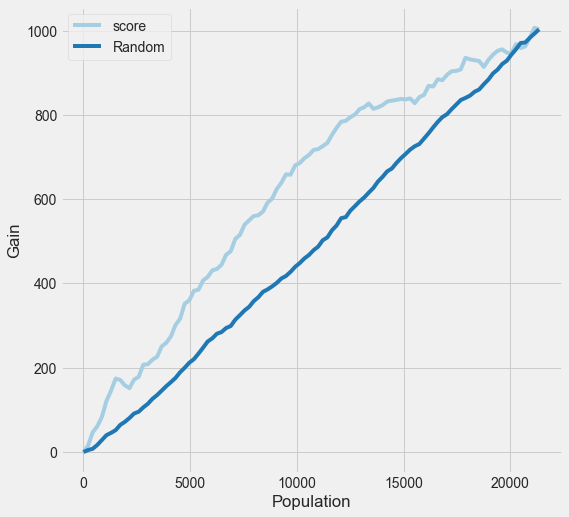

In [186]:
cmetrics.plot_gain(
    eval_data,
    treatment_col='treatment',
    outcome_col='visit',
)

In [197]:
upeval = pylift.eval.UpliftEval(
    treatment=eval_data['treatment'],
    outcome=eval_data['visit'],
    prediction=eval_data['score'],
    n_bins=10
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:title={'center':'Uplift curve'}, xlabel='Fraction of data', ylabel='Lift'>

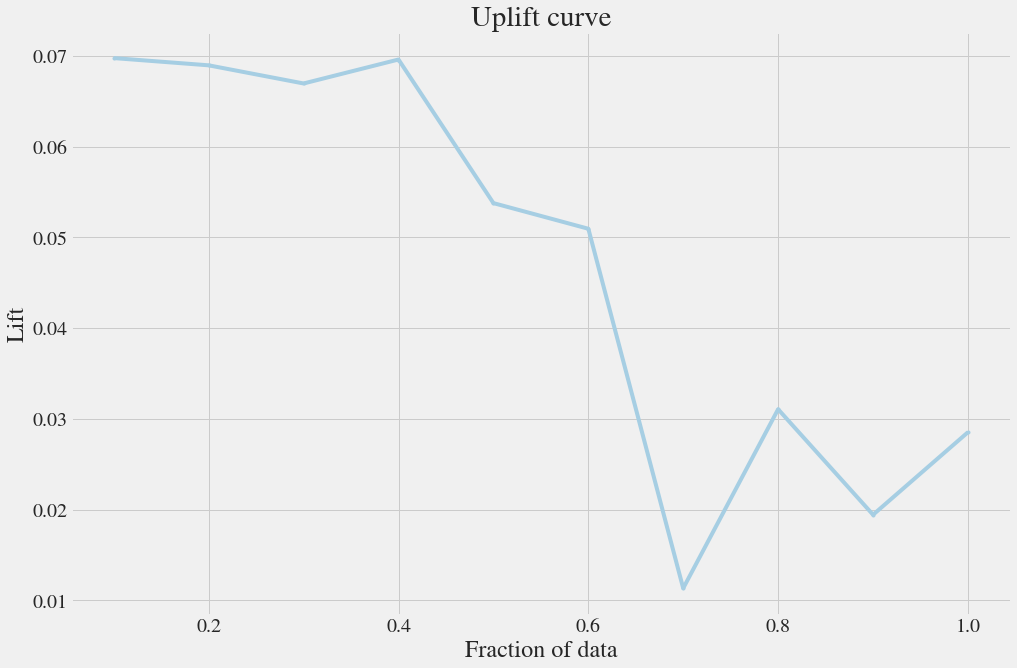

In [198]:
upeval.plot_uplift()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


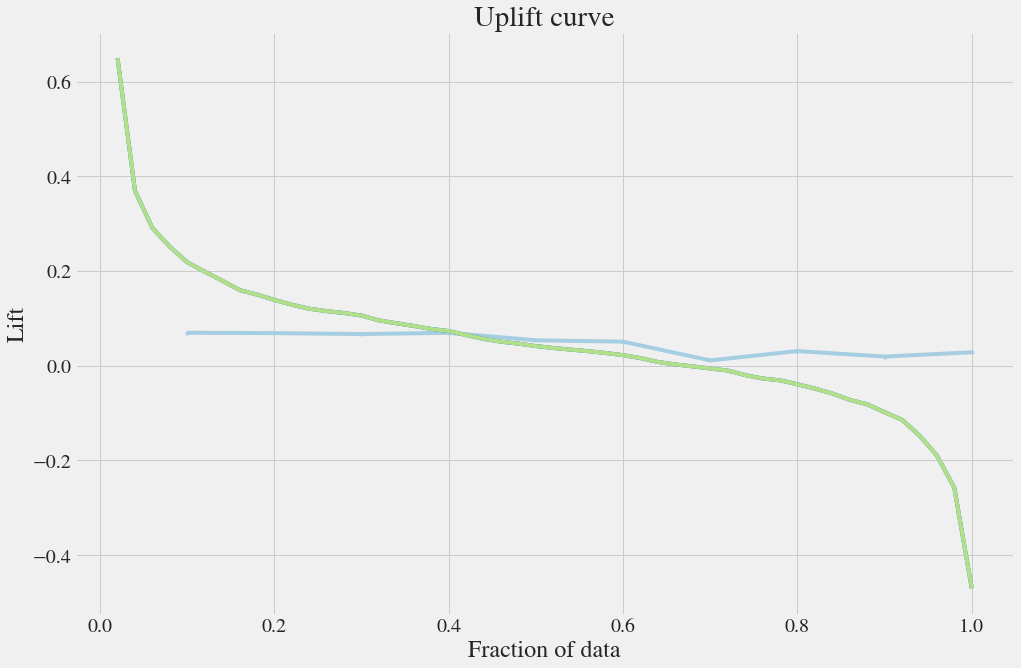

In [199]:
upeval.plot_uplift()
plt.plot(*pylift_utils.plot_uplift_prediction(upeval=upeval, n_bins=50))